## Optimizing Safe Control Policy over Trajectories

In [8]:
import numpy as np
import torch
import torch.nn as nn
torch.set_default_dtype(torch.float64)

import os
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import itertools

from utils import load_data
import hardnet_aff
import baseline_dc3
import baseline_nn

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

matplotlib.rcParams['text.usetex'] = True
plt.style.use('seaborn-whitegrid')

def simulate_policies(data, init_state, cost_fn, policy_list, label_list, color_list, linestyle_list, nstep=None, dt=None):
    """
    Plot the trajectories given policies.
    """
    fig = plt.figure(figsize=(4, 4))

    ## plot obstacles
    for obs in data.obs_list:
        ellipse = Ellipse((obs.cx, obs.cy), width=2*obs.rx, height=2*obs.ry, angle=0, color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
        plt.gca().add_artist(ellipse)

    for policy, label, c, ls in zip(policy_list, label_list, color_list, linestyle_list):
        policy.eval()
        if label == "CBF-QP":
            obs_list_original = data._obs_list
            data._obs_list = data._obs_list[:1]
        cost, traj = data.run_episode(policy, init_state, cost_fn, nstep=nstep, dt=dt, isTest=True, saveTraj=True)
        center_traj = data.sys.get_center(traj[:,0,:]).detach().cpu().numpy()
        plt.plot(center_traj[:,0], center_traj[:,1], ls, color=c, label=label+' (%.2f)'%cost[0], markersize=2, alpha=0.5)
        if label == "CBF-QP":
            data._obs_list = obs_list_original
    
    # plot start and goal point
    plt.scatter(center_traj[0,0], center_traj[0,1], s=100, color="k", facecolor="none", alpha=0.75, label="init. position")
    # plt.scatter(0.0, 0.0, s=100, color="purple", alpha=0.75, label="target position")

    # plt.title('Simulation Result')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend(ncol=1)
    plt.grid(True)
    plt.axis('equal')
    plt.xlim([-4,.5])
    # plt.ylim([-2.5,1.])
    plt.ylim([-1.5,1.])

    # 
    ax = plt.gca()
    handles, _labels = ax.get_legend_handles_labels()
    flip = lambda items: itertools.chain(*[items[i::2] for i in range(2)])
    ax.legend(flip(handles), flip(_labels), ncol=2, frameon=True)

    plt.show()

    return fig

def load_net_hardnet(data, args, path):
    net = hardnet_aff.HardNetAff(data, args).to(DEVICE)
    with open(os.path.join(path), 'rb') as f:
        net.load_state_dict(torch.load(f, map_location=DEVICE))
    net.set_projection(True)
    return net

def load_net_dc3(data, args, path):
    net = baseline_dc3.NNSolver(data, args).to(DEVICE)
    with open(os.path.join(path), 'rb') as f:
        net.load_state_dict(torch.load(f, map_location=DEVICE))
    return net

def load_net_nn(data, args, path):
    net = baseline_nn.TestProjNet(data, args).to(DEVICE)
    with open(os.path.join(path), 'rb') as f:
        net.load_state_dict(torch.load(f, map_location=DEVICE))
    return net

tableau10 = [(31, 119, 180), (255, 127, 14),
                (44, 160, 44), (214, 39, 40),
                (227, 119, 194), (23, 190, 207), 
                (127, 127, 127), (140, 86, 75),
                (188, 189, 34), (148, 103, 189)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau10)):
    r, g, b = tableau10[i]
    tableau10[i] = (r / 255., g / 255., b / 255.)

folder_save = 'results/figures'

/tmp/ipykernel_618770/2713595846.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
from datasets.cbf.safe_control import Obstacle

policy_list = []
label_list = []
prob_type = 'cbf'
net_str = 'net.dict' # ex) net_epoch0.dict, net.dict

sys.argv = ['hardnet_aff.py', '--probType', prob_type]
args = hardnet_aff.get_args('hardnetAff')
data = load_data(args, DEVICE)

class Nominal(nn.Module):
    def __init__(self, data):
        super().__init__()
        self._data = data

    def forward(self, x, isTest=False):
        return self._data.get_nominal_control(x) * 0
policy_nominal = Nominal(data)
policy_list.append(policy_nominal)
label_list.append('Nominal')

net = hardnet_aff.HardNetAff(data, args).to(DEVICE)
with torch.no_grad():
    net._net[-1].weight *= 0
    net._net[-1].bias *= 0
net.set_projection(True)
policy_list.append(net)
label_list.append('CBF-QP')

# NN
sys.argv = ['baseline_nn.py', '--probType', prob_type, '--softWeight', '0.0']
args = baseline_nn.get_args('baselineNN')
path = 'results/SafeControl-2-2-0-1000/baselineNN_noSoft/250430-064745/' + net_str
policy_list.append(load_net_nn(data, args, path))
label_list.append('NN')

# Soft
sys.argv = ['baseline_nn.py', '--probType', prob_type]
args = baseline_nn.get_args('baselineNN')
path = 'results/SafeControl-2-2-0-1000/baselineNN/250430-064745/' + net_str
policy_list.append(load_net_nn(data, args, path))
label_list.append('Soft')


# DC3
sys.argv = ['baseline_dc3.py', '--probType', prob_type]
args = baseline_dc3.get_args('baselineDC3')
path = 'results/SafeControl-2-2-0-1000/baselineDC3/250430-120302/' + net_str
policy_list.append(load_net_dc3(data, args, path))
label_list.append('DC3')


# hardnet
sys.argv = ['hardnet_aff.py', '--probType', prob_type]
args = hardnet_aff.get_args('hardnetAff')
path = 'results/SafeControl-2-2-0-1000/hardnetAff/250430-064745/' + net_str
policy_list.append(load_net_hardnet(data, args, path))
label_list.append('HardNet-Aff')


linestyle_list = [':o' if 'HardNet' in label else '-*' for label in label_list]

hardnetAff: {'probType': 'cbf', 'suffix': '', 'seed': 123, 'nVar': 2, 'nIneq': 2, 'nEq': 0, 'nEx': 1000, 'epochs': 1000, 'batchSize': 100, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'softWeight': 0.01, 'softWeightEqFrac': 0.0, 'softEpochs': 0}
baselineNN: {'probType': 'cbf', 'suffix': '', 'seed': 123, 'nVar': 2, 'nIneq': 2, 'nEq': 0, 'nEx': 1000, 'epochs': 1000, 'batchSize': 100, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'softWeight': 0.0, 'softWeightEqFrac': 0.0, 'useTestProj': False}
baselineNN: {'probType': 'cbf', 'suffix': '', 'seed': 123, 'nVar': 2, 'nIneq': 2, 'nEq': 0, 'nEx': 1000, 'epochs': 1000, 'batchSize': 100, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'softWeight': 0.01, 'softWeightEqFrac': 0.0, 'useTestProj': False}
baselineDC3: {'probType': 'cbf', 'suffix': '', 'seed': 123, 'nVar': 2, 'nIneq': 2, 'nEq': 0, 'nEx': 1000, 'epochs': 1000, 'batchSize': 100, 'lr': 0.000

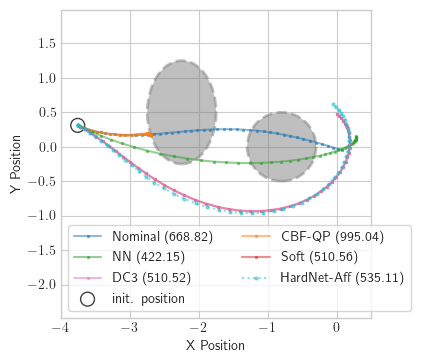

In [ ]:
dt, nstep = 0.02, 50
np.random.seed(123)
init_state = torch.tensor(data._sys.generate_states(1), device=DEVICE)

cost_fn = data.evaluate
fig = simulate_policies(data, init_state, cost_fn, policy_list, label_list, tableau10, linestyle_list, nstep, dt)
# policy.set_projection(False)
fig.savefig(folder_save+'/cbf.pdf',dpi=300, bbox_inches='tight')

### Table

In [1]:
import numpy as np
import os
from utils import get_results, get_table_from_dict, get_latex_from_table

exp_dir = os.path.join('results', 'SafeControl-2-2-0-1000')
exp_status_dict, stats_dict = get_results(exp_dir, total_epoch=1000)

metrics = ['test_eval', 'test_eq_max', 'test_eq_mean', 'test_eq_nviol',
            'test_ineq_max', 'test_ineq_mean', 'test_ineq_nviol', 'test_time', 'train_time']
metrics_renaming = ['Obj. value', 'Max eq viol.', 'Mean eq viol.', 'Num eq viol.',
                    'Max ineq viol.', 'Mean ineq viol.', 'Num ineq viol.', 'Test Time (ms)', 'Train Time (min)']
baselines = ['baselineNN_noSoft', 'baselineNN_noSoft_testProj', 'baselineNN', 'baselineNN_testProj', 
             'baselineDC3', 'baselineDC3_testProj']
ours = ['hardnetAff']
methods_renaming_dict = dict((
        ('baselineDC3', 'DC3'),
        ('baselineDC3_testProj', 'DC3+Proj'),
        ('baselineNN_noSoft', 'NN'),
        ('baselineNN_noSoft_testProj', 'NN+Proj'),
        ('baselineNN', 'Soft'),
        ('baselineNN_testProj', 'Soft+Proj'),
        ('hardnetAff', 'HardNet-Aff')
    ))

df, missing_methods = get_table_from_dict(stats_dict, metrics, baselines + ours, test_time_unit='ms', train_time_unit='min')
df.index = [methods_renaming_dict[x] if x in methods_renaming_dict else x for x in df.index]
df.columns = metrics_renaming

df

Reading baselineNN...
Reading hardnetAff...
Reading baselineNN_noSoft...
Reading baselineDC3...
missing methods: ['baselineNN_noSoft_testProj', 'baselineNN_testProj', 'baselineDC3_testProj']


,Obj. value,Max eq viol.,Mean eq viol.,Num eq viol.,Max ineq viol.,Mean ineq viol.,Num ineq viol.,Test Time (ms),Train Time (min)
NN,421.92 (0.15),0.00 (0.00),0.00 (0.00),0.00 (0.00),157.62 (0.90),118.92 (0.55),2.00 (0.00),0.49 (0.11),180.22 (1.25)
Soft,480.10 (0.54),0.00 (0.00),0.00 (0.00),0.00 (0.00),6.92 (0.05),3.95 (0.10),1.96 (0.06),0.89 (0.76),180.10 (0.58)
DC3,480.12 (0.59),0.00 (0.00),0.00 (0.00),0.00 (0.00),6.90 (0.08),3.93 (0.13),1.94 (0.10),24.17 (3.18),758.50 (61.96)
HardNet-Aff,518.85 (8.71),0.00 (0.00),0.00 (0.00),0.00 (0.00),0.00 (0.00),0.00 (0.00),0.00 (0.00),3.16 (0.32),239.69 (1.46)


### Dataset visualization

In [ ]:
X = data.sys.get_center(data.trainX).detach().cpu().numpy()

plt.figure(figsize=(4, 4))
plt.scatter(X[:,0], X[:,1], s=1)
for obs in data.obs_list:
    ellipse = Ellipse((obs.cx, obs.cy), width=2*obs.rx, height=2*obs.ry, angle=0, color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
    plt.gca().add_artist(ellipse)